# Maintenance 
***

In [154]:
# Importation librairies
import pandas as pd 
pd.options.mode.chained_assignment = None  # default='warn'
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from sklearn.metrics import homogeneity_score, adjusted_rand_score, adjusted_mutual_info_score
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from collections import Counter
from sklearn.metrics import silhouette_score
#from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from mpl_toolkits.mplot3d import Axes3D
import scipy.cluster.hierarchy as sch
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import normalize
import plotly.express as px

# Normalization
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, QuantileTransformer


## 1. Récupération de données 
***

In [187]:
data_cleaned = pd.read_csv('D:\Projet Classrooms\Projet_5\data_cleaned.csv')

In [188]:
data_cleaned.head()

,Recency,Frequency,Monetary_sum,Delivery_time,Score_mean,last_order_date
0,1445,1,141.90,6.0,5.0,2018-05-10 10:56:27
1,1448,1,27.19,3.0,4.0,2018-05-07 11:11:27
2,1870,1,86.22,25.0,3.0,2017-03-10 21:05:03
3,1654,1,43.62,20.0,4.0,2017-10-12 20:29:41
4,1621,1,196.89,13.0,5.0,2017-11-14 19:45:42


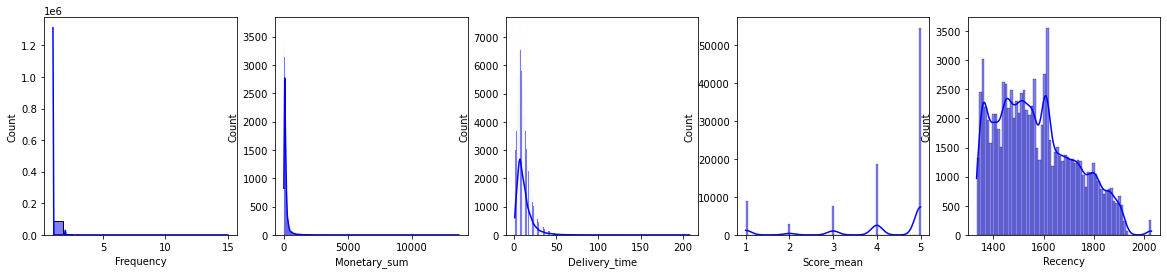

In [189]:
fig, axes = plt.subplots(1, 5, figsize=(20,4))
axes = axes.flatten()
for col, ax in zip(['Frequency','Monetary_sum','Delivery_time','Score_mean','Recency'], axes):
    sns.histplot(data_cleaned[col], ax = ax, color= 'b', kde=True)
plt.show()


# Passage au Log:

    * Frequency
    * Monetary_sum
    * Delivery_time

In [190]:
data_cleaned['Frequency']= np.log1p(data_cleaned['Frequency'])
data_cleaned['Monetary_sum']= np.log1p(data_cleaned['Monetary_sum'])
data_cleaned['Delivery_time']= np.log1p(data_cleaned['Delivery_time'])

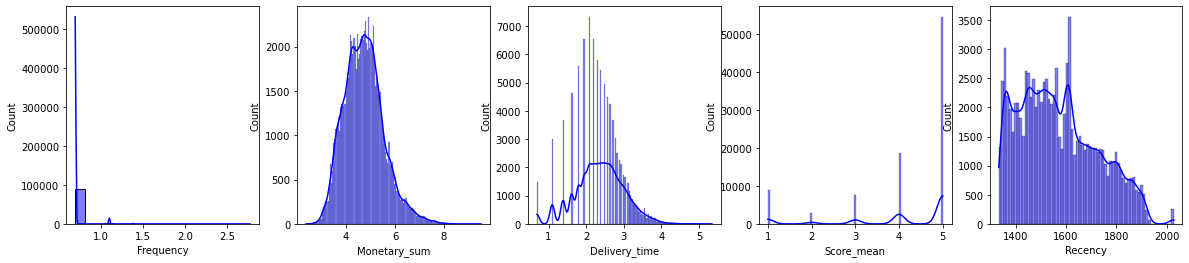

In [191]:
fig, axes = plt.subplots(1, 5, figsize=(20,4))
axes = axes.flatten()
for col, ax in zip(['Frequency','Monetary_sum','Delivery_time','Score_mean','Recency'], axes):
    sns.histplot(data_cleaned[col], ax = ax, color= 'blue', kde=True)
plt.show()

#### Correction de Data Type

In [192]:
data_cleaned['last_order_date'] = data_cleaned['last_order_date'].astype('datetime64')

In [193]:
display(data_cleaned['last_order_date'].min(), data_cleaned['last_order_date'].max())

Timestamp('2016-10-03 16:56:50')

Timestamp('2018-08-29 15:00:37')

In [194]:
# déficnition de dates limites pour la création de data-set

date_0 = dt.datetime(2017, 12, 31, 0, 0,0)
date_1 = dt.datetime(2018,  2,  1, 0, 0,0)
date_2 = dt.datetime(2018,  3,  1, 0, 0,0)
date_3 = dt.datetime(2018,  4,  1, 0, 0,0)
date_4 = dt.datetime(2018,  5,  1, 0, 0,0)
date_5 = dt.datetime(2018,  6,  1, 0, 0,0)
date_6 = dt.datetime(2018,  7,  1, 0, 0,0)
date_7 = dt.datetime(2018,  8,  1, 0, 0,0)
date_8 = dt.datetime(2018,  8,  29,0, 0,0)

date_threshold = [date_0, date_1, date_2, date_3, date_4,date_5, date_6, date_7, date_8]

In [195]:

X_0 = data_cleaned[data_cleaned['last_order_date'] <= date_0]
X_0 = X_0.drop(columns='last_order_date', axis= 1)    

X_1 = data_cleaned[data_cleaned['last_order_date'] <= date_1]
X_1 = X_1.drop(columns='last_order_date', axis= 1)

X_2 = data_cleaned[data_cleaned['last_order_date'] <= date_2]
X_2 = X_2.drop(columns='last_order_date', axis= 1)

X_3 = data_cleaned[data_cleaned['last_order_date'] <= date_3]
X_3 = X_3.drop(columns='last_order_date', axis= 1)

X_4 = data_cleaned[data_cleaned['last_order_date'] <= date_4]
X_4 = X_4.drop(columns='last_order_date', axis= 1)

X_5 = data_cleaned[data_cleaned['last_order_date'] <= date_5]
X_5 = X_5.drop(columns='last_order_date', axis= 1)

X_6 = data_cleaned[data_cleaned['last_order_date'] <= date_6]
X_6 = X_6.drop(columns='last_order_date', axis= 1)

X_7 = data_cleaned[data_cleaned['last_order_date'] <= date_7]
X_7 = X_7.drop(columns='last_order_date', axis= 1)

X_8 = data_cleaned[data_cleaned['last_order_date'] <= date_8]
X_8 = X_8.drop(columns='last_order_date', axis= 1)

In [196]:
X_0.shape, X_1.shape, X_2.shape, X_3.shape, X_4.shape, X_5.shape, X_6.shape, X_7.shape, X_8.shape

((41358, 5),
 (48212, 5),
 (54455, 5),
 (61230, 5),
 (67836, 5),
 (74432, 5),
 (80420, 5),
 (86444, 5),
 (92722, 5))

In [197]:
delta_time = int((data_cleaned['last_order_date'].max() - data_cleaned['last_order_date'].min())/np.timedelta64(1,'M'))
delta_time

22

****
    * Entre la première commande et la dèrnière on est prèsque à 23 mois d'intervalle, pour savoir si les clients changent de cluster, on va itérer le K-Means sur toute la période avec des deltas de 1 mois et calculer le score ARI, puis comparer avec les données initiales X_0.


## 2. Entrainement du modèle M_0
***


In [198]:
inertia = []                       # inertia of clusters
k_cluster = [2,3,4,5,6,7,8,9,10]   # number of clusters
#s_scores = []                      # silhouette scores

for k in k_cluster:
    model = KMeans(n_clusters = k).fit(X_0_scaled)
    inertia.append(model.inertia_)  # data for the elbow method
    
    #silhouette_avg = silhouette_score(X_0_scaled, model.labels_)
    #s_scores.append(silhouette_avg) # data for the silhouette score method

In [199]:
#plt.plot(k_cluster, s_scores, marker='o')
#plt.xlabel('Number of clusters')
#plt.ylabel('silhouette_score')

In [200]:
# Plotting a bar graph to compare the results
#k_cluster = [2,3,4,5,6,7,8,9,10]
#plt.bar(k_cluster, s_scores, color= 'blue')
#plt.xlabel('Number of clusters', fontsize = 20)
#plt.ylabel('S(i)', fontsize = 20)
#plt.show()

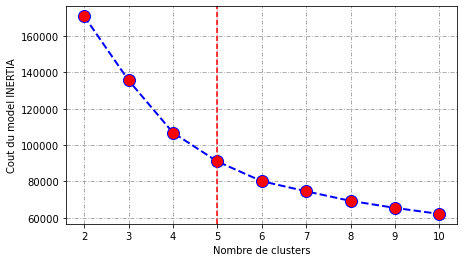

In [201]:
plt.figure(figsize=(7, 4))
plt.plot(k_cluster, inertia, color='blue', marker='o', linestyle='dashed', linewidth=2, markersize=12,
        #mec= 'yellow',
         mfc= 'red',
    mfcalt='black')
plt.xlabel('Nombre de clusters')
plt.ylabel('Cout du model INERTIA')
plt.grid(True, color='0.6', dashes=(5,2,1,2))
plt.axvline(5, ls="--", c="red")
        #plt.axvline(6, ls="--", c="red")
plt.grid(True, color='0.6', dashes=(5,2,1,2))

In [202]:
'''  1./--> on construit X_0 et M_0
        --> X_0 représente toutes données avant 2018 : last_order_date  
        --> puis entrainer M_0 sur X_0
        --> X_0_scaled: le scaler pour ces données 
        --> puis faire juste un fit() de M_0
'''
S_0 = StandardScaler()

X_0_scaled = S_0.fit_transform(X_0)
# Kmeans pour T_0

M_0 = KMeans(n_clusters = 5)
M_0.fit(X_0_scaled)


KMeans(n_clusters=5)

In [203]:
''' 2./  --> on crée une liste de dataframe [X1, X2, X3, X4]
         --> X1 = X0+ LES ACHATS EFFECTU2E UN MOIS APRES X0
         --> X1 = TOUTES LES DONNES AVANT LAST ORDER DATE 01/02/2018
         .
         ..
         X2 = TOUTES LES DONNES AVANT LAST ORDER DATE 01/03/2018
         ainsi de suite 
         
    3./  --> on va iéter tous ça dans une boucle puis concatiner pour comparer 
'''
# Calculate ARI score
list_data =[X_1,X_2,X_3,X_4,X_5,X_6, X_7, X_8] 
p = 0
ari_score = []

for x in list_data:
     
    # prédir M0
    x_scaled = S_0.transform(x)
    p_0 = M_0.predict(x_scaled)
   
    # prédir M_new
    M_new = KMeans(n_clusters=5)
    x_scaled = StandardScaler().fit_transform(x)
    M_new.fit(x_scaled)
    p_new = M_new.predict(x_scaled)
    p+=1
     # compute_score p0 pnew
    ari_pred = adjusted_rand_score(p_0, p_new)
    #score = ariscore(p0, p_new.labels)
    ari_score.append(['2018-0' + str(p),ari_pred])

In [204]:
ari_score = pd.DataFrame(ari_score, columns=["Periode", "ARI_Score"])

In [205]:
ari_score 


,Periode,ARI_Score
0,2018-01,0.837457
1,2018-02,0.666338
2,2018-03,0.623197
3,2018-04,0.628717
4,2018-05,0.623724
5,2018-06,0.646247
6,2018-07,0.580594
7,2018-08,0.537032


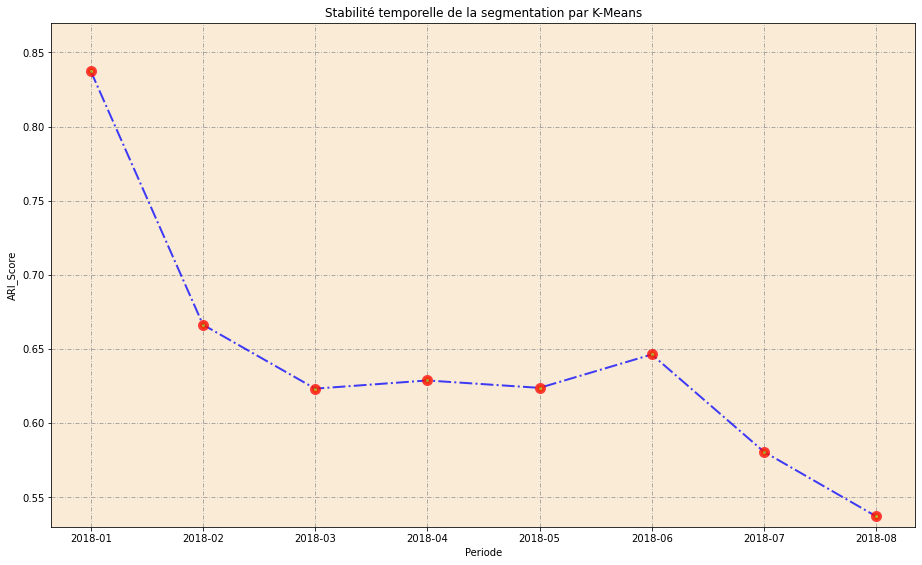

In [206]:
fig = plt.figure(figsize=(12,7))
axes = fig.add_axes([0,0,1,1])
axes.plot( ari_score.Periode, ari_score.ARI_Score, color = 'blue', alpha=.75, lw= 2, ls= '-.', marker= 'o',
          markersize=7, markerfacecolor='y', markeredgecolor='red', markeredgewidth=4 )

#axes.set_xlim([0,8])
axes.set_ylim([0.53,0.87])
axes.set_xlabel('Periode')
axes.set_ylabel('ARI_Score')
axes.set_title('Stabilité temporelle de la segmentation par K-Means')
#axes.axvline(5, color='green', ls='--')
axes.axhline(7, color='blue', ls='--')
axes.grid(True, color='0.6', dashes=(5,2,1,2))
axes.set_facecolor("#faebd7")